# A quanvolutional neural network for weld classification

## Prerequisite

If you are not familiar with convolutional or quanvolutional networks and layers, a demonstration is provided in the [quanvolutional.ipynb](quanvolutional.ipynb) file.

In [4]:
# Import Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.src import activations
from keras.src import initializers
from keras.src import ops
from keras.src.layers.layer import Layer

# Import Matplotlib
import matplotlib.pyplot as plt

# Auxiliary modules
import json
import os
from PIL import Image

# Accelerate with GPU
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Path

The code for extracting the dataset is manual and based on an existing [Kaggle submission]('https://www.kaggle.com/code/mayankgupta1609/model-1'). Please note this step may take at least ten minutes to conclude and consume large amounts of memory.

In [6]:

# Dataset
SAVE_PATH = "/home/samaria/S/Trainset/al5083/"           # Data saving folder (locally)
PREPROCESS = True                           # If False, skip quantum processing and load data from SAVE_PATH
SETSEED = False
if SETSEED:
    np.random.seed(0)           # Seed for NumPy random number generator
    tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Space and time management
LABEL_LIMIT = 1024                # Mechanism to save time and space by label count
SCALE_FACTOR = 16                 # Downscale factor

# Image size
HEIGHT = 800
WIDTH = 974
LABELS = 6                # Units of dense second layer
LABEL_TITLES = ["good","burn","contamination","lack_fusion", "misalignment", "lack_penetration"]

# Manual extraction Source: https://www.kaggle.com/code/mayankgupta1609/model-1
def load_data(path, subpath, limit=LABEL_LIMIT):
    images, labels, defectives, sources = [], [], [], []
    labelsource = None
    with open(SAVE_PATH + "{0:s}/{0:s}.json".format(subpath), 'r') as json_file:
        labelsource = json.load(json_file) # returns a JSON of source-label pairs
    label_count = [0]*LABELS
    for folder in os.listdir(path + subpath):
        folder_path = os.path.join(path + subpath, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = labelsource[key_name]

                # Mechanism to save time and space
                if(label_count[label] >= limit):
                    continue
                if(len(images) >= LABELS*limit):
                    break
                label_count[label] += 1

                # Extract image, with downscaling as mechanism to save space
                image = Image.open(img_path)
                image = image.resize((HEIGHT//SCALE_FACTOR, WIDTH//SCALE_FACTOR), Image.Resampling.LANCZOS)

                # Convert to numpy, and save label
                images.append(np.array(image))
                labels.append(label)
                defectives.append([int(bool(label))])
                sources.append(key_name)
                
                if(len(images)%100==0):
                    print(f"Total images loaded : {len(images)}, Label count : {label_count}", end = '\r')
            # End of image processing
        # Skip non-folders
    # End of folder processing, return normalized numpy array of images, labels array, and sources list. 
    # Add extra dimension for convolution channels
    return np.array(np.array(images)[..., tf.newaxis], requires_grad=False) / 255, np.array(labels), np.array(defectives), sources

train_images, train_labels, train_defective, train_sources = load_data(SAVE_PATH, "train")
print()
test_images, test_labels, train_defective, test_sources = load_data(SAVE_PATH, "test", 128)
print()
RANDOMINDEX = np.random.randint(len(train_images))
print("Size of initial tensor #{3:d}: {0:s}, status: {1:d}, filename: '{2:s}'".format( \
    str(train_images[RANDOMINDEX].shape), train_labels[RANDOMINDEX], train_sources[RANDOMINDEX], RANDOMINDEX))

Total images loaded : 6100, Label count : [1024, 980, 1024, 1024, 1024, 1024]
Total images loaded : 700, Label count : [128, 128, 128, 60, 128, 128]
Size of initial tensor #2982: (60, 50, 1), status: 5, filename: '170904-115503-Al 2mm/frame_00921.png'


## Epoch and subsampling settings

You can adjust the number of epochs and the batch size per iteration.

In [7]:
# Epochs
n_epochs = 100                   # Number of optimization epochs
n_train = -1                     # Size of the train dataset (-1 for entire)
n_valid = -1                     # Size of the validation dataset (-1 for entire)
n_test = -1                      # Size of the test dataset (-1 for entire)
batch_size = 16                  # Batch size used for training iterations

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

## Displaying sample data

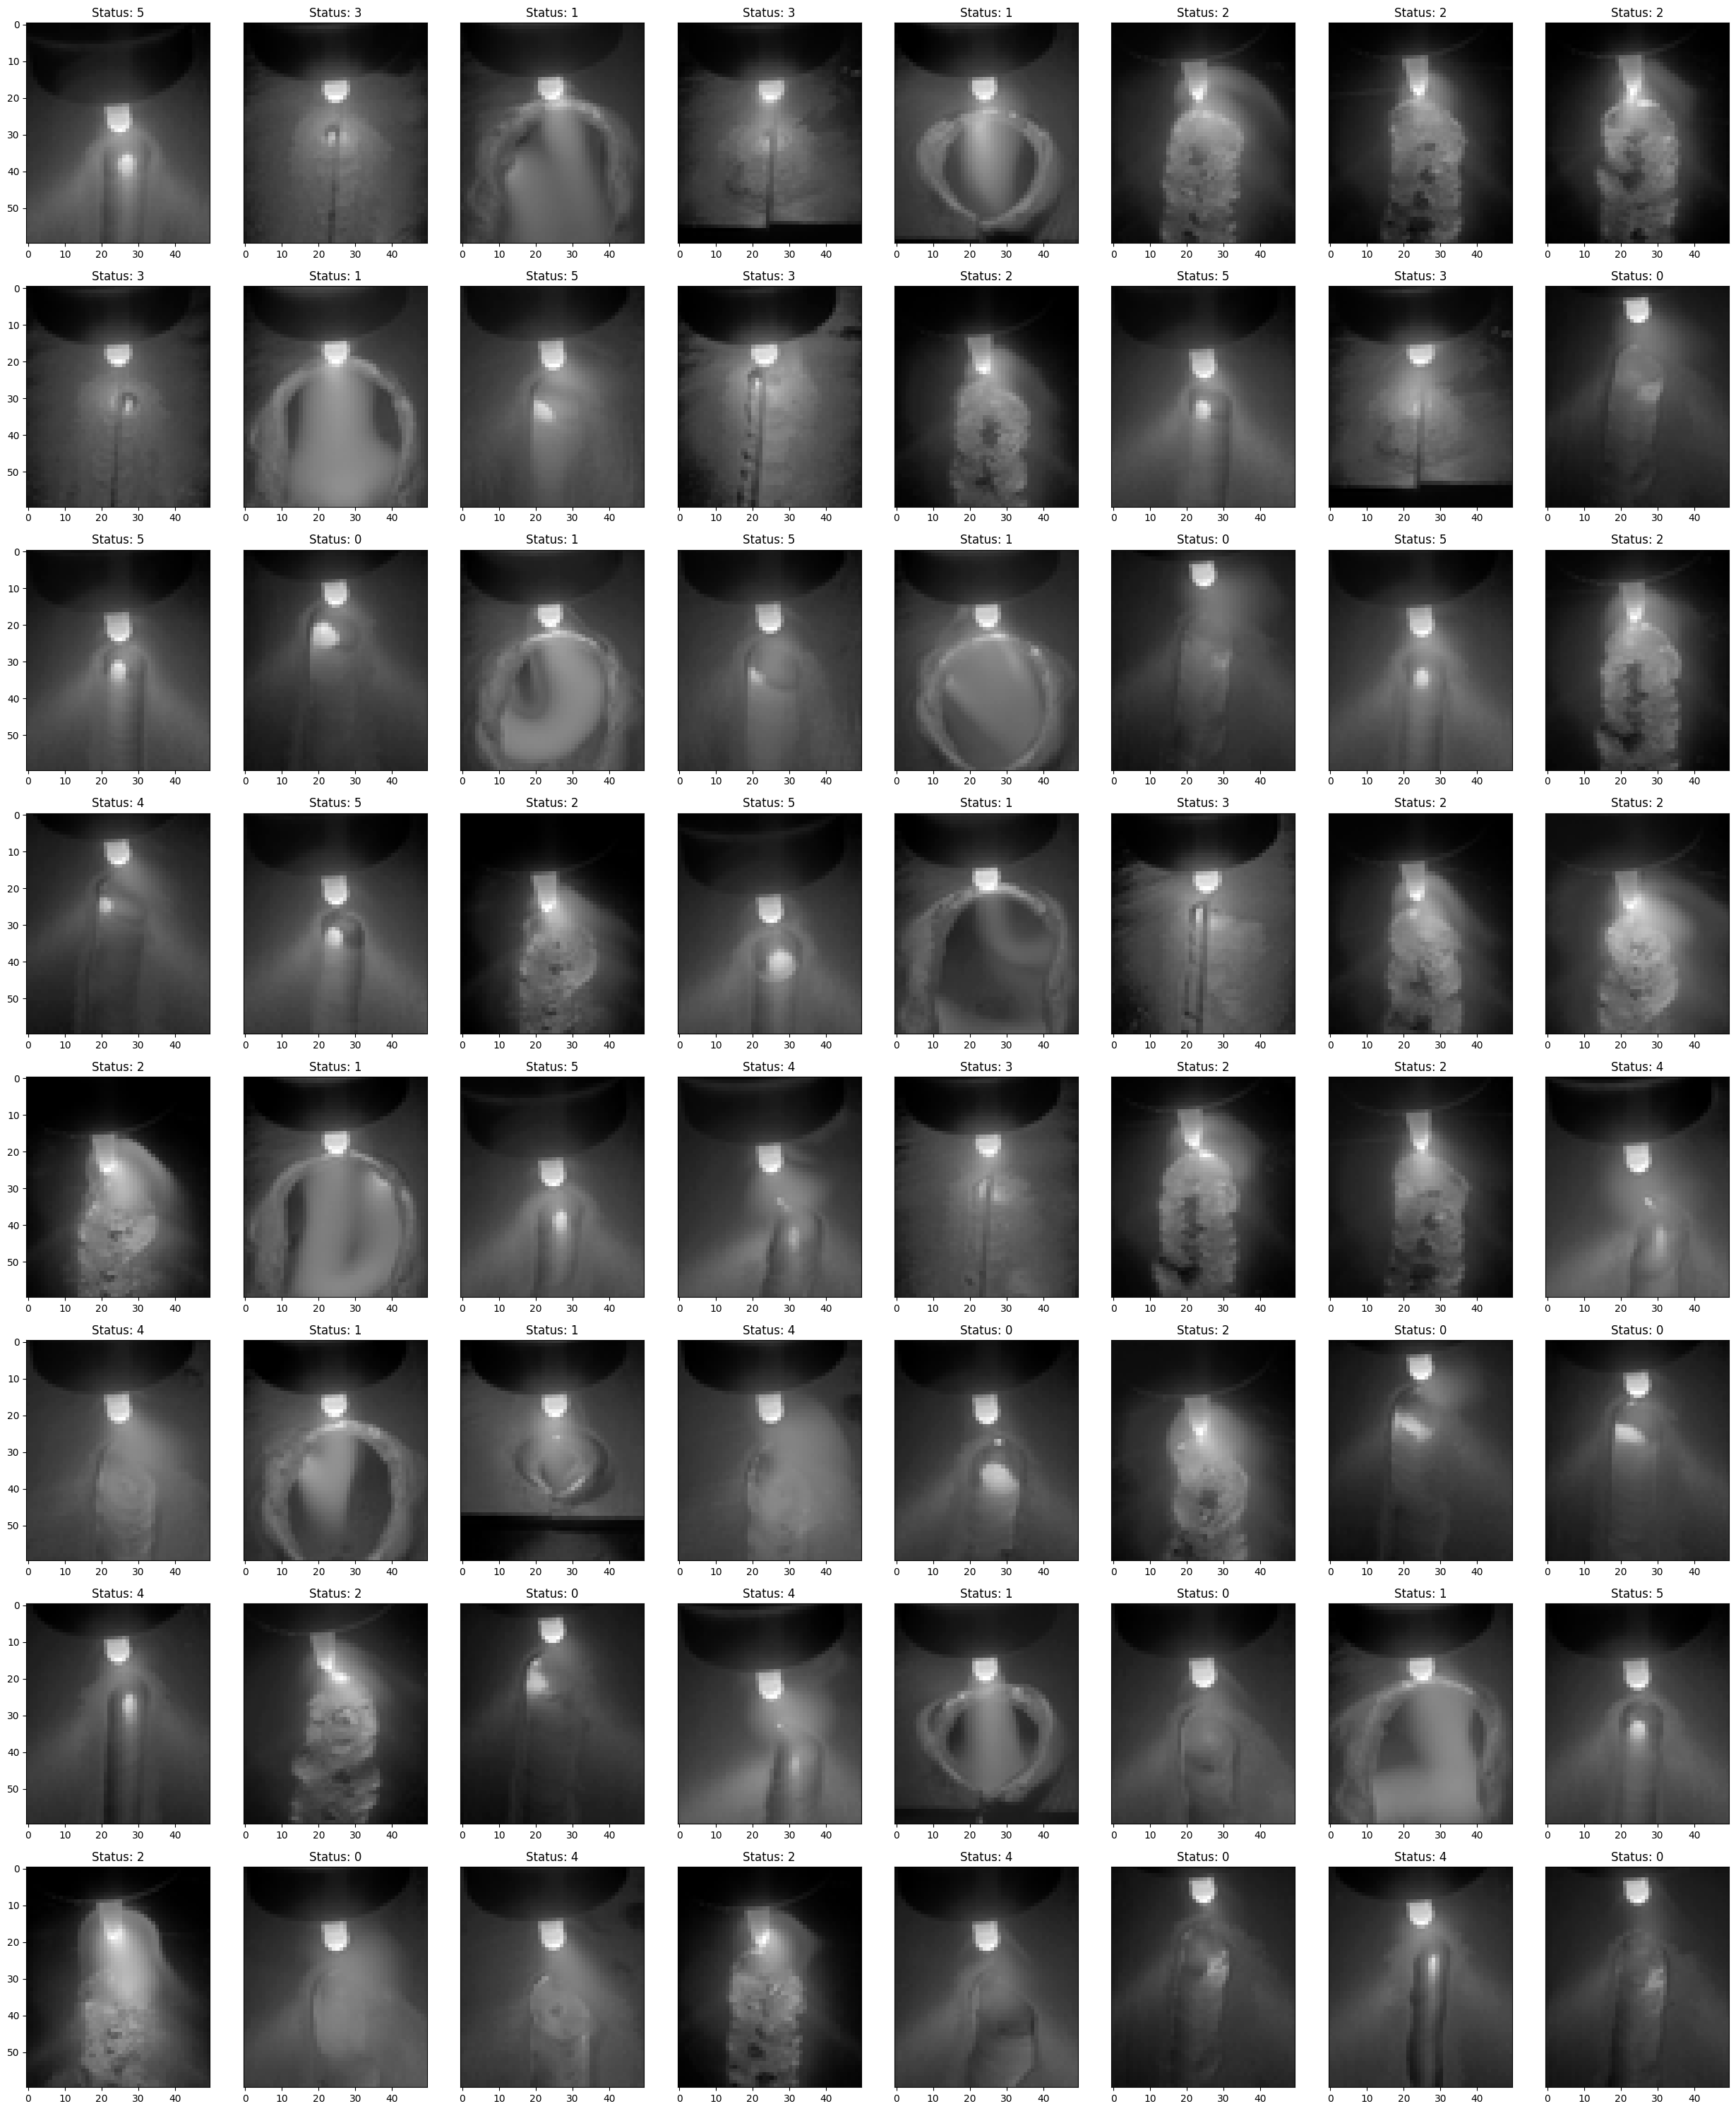

In [8]:
DISPLAYSQRT = 8
fig, axes = plt.subplots(DISPLAYSQRT, DISPLAYSQRT, figsize=(25, 30))
# Column number is the sample used
for i in range(DISPLAYSQRT):
    for j in range(DISPLAYSQRT):
        # Randomize
        RANDOMINDEX = np.random.randint(len(train_images))
        # Plot title
        axes[i, j].set_title("Status: {0:d}".format(train_labels[RANDOMINDEX]))
        if j != 0:
            axes[i, j].yaxis.set_visible(False)
        axes[i, j].imshow(train_images[RANDOMINDEX, :, :, 0], cmap="gray")
plt.tight_layout()
plt.show()

## Models and Hyperparameters

The model is prescribed by the original paper.

In [9]:
seq = keras.models.Sequential([
    keras.layers.Resizing(HEIGHT//2, WIDTH//2),
    keras.layers.Conv2D(16, 5, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=5, strides=2),
    keras.layers.Conv2D(32, 5, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=5, strides=2),
    keras.layers.Conv2D(64, 5, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=5, strides=2),
    keras.layers.Conv2D(128, 5, activation="relu", strides=1),
    keras.layers.MaxPooling2D(pool_size=5, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(LABELS, activation="softmax")
])

def cmodel(model):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training the dataset classically

In [10]:
c_history = cmodel(seq).fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

I0000 00:00:1723171569.871466  188951 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723171569.875784  188951 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723171569.879304  188951 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723171570.002884  188951 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/100


I0000 00:00:1723171571.578028  192936 service.cc:146] XLA service 0x7a9ce4006780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723171571.578050  192936 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-08-08 22:46:11.602409: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 22:46:11.763865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1723171583.847530  192936 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


384/384 - 56s - 147ms/step - accuracy: 0.7695 - loss: 0.5648 - val_accuracy: 0.4459 - val_loss: 6.6010
Epoch 2/100
Epoch 2/100
384/384 - 26s - 67ms/step - accuracy: 0.9329 - loss: 0.1658 - val_accuracy: 0.4029 - val_loss: 6.7644
Epoch 3/100
384/384 - 26s - 67ms/step - accuracy: 0.9751 - loss: 0.0654 - val_accuracy: 0.3716 - val_loss: 7.8792
Epoch 4/100
384/384 - 26s - 67ms/step - accuracy: 0.9867 - loss: 0.0386 - val_accuracy: 0.4107 - val_loss: 9.7725
Epoch 5/100
384/384 - 26s - 67ms/step - accuracy: 0.9886 - loss: 0.0333 - val_accuracy: 0.3716 - val_loss: 6.8041
Epoch 6/100
384/384 - 26s - 67ms/step - accuracy: 0.9901 - loss: 0.0281 - val_accuracy: 0.3990 - val_loss: 5.7738
Epoch 7/100
384/384 - 26s - 67ms/step - accuracy: 0.9909 - loss: 0.0292 - val_accuracy: 0.2008 - val_loss: 5.2325
Epoch 8/100
384/384 - 26s - 67ms/step - accuracy: 0.9920 - loss: 0.0233 - val_accuracy: 0.4068 - val_loss: 6.9213
Epoch 9/100
384/384 - 26s - 67ms/step - accuracy: 0.9884 - loss: 0.0348 - val_accuracy:

## Displaying the results

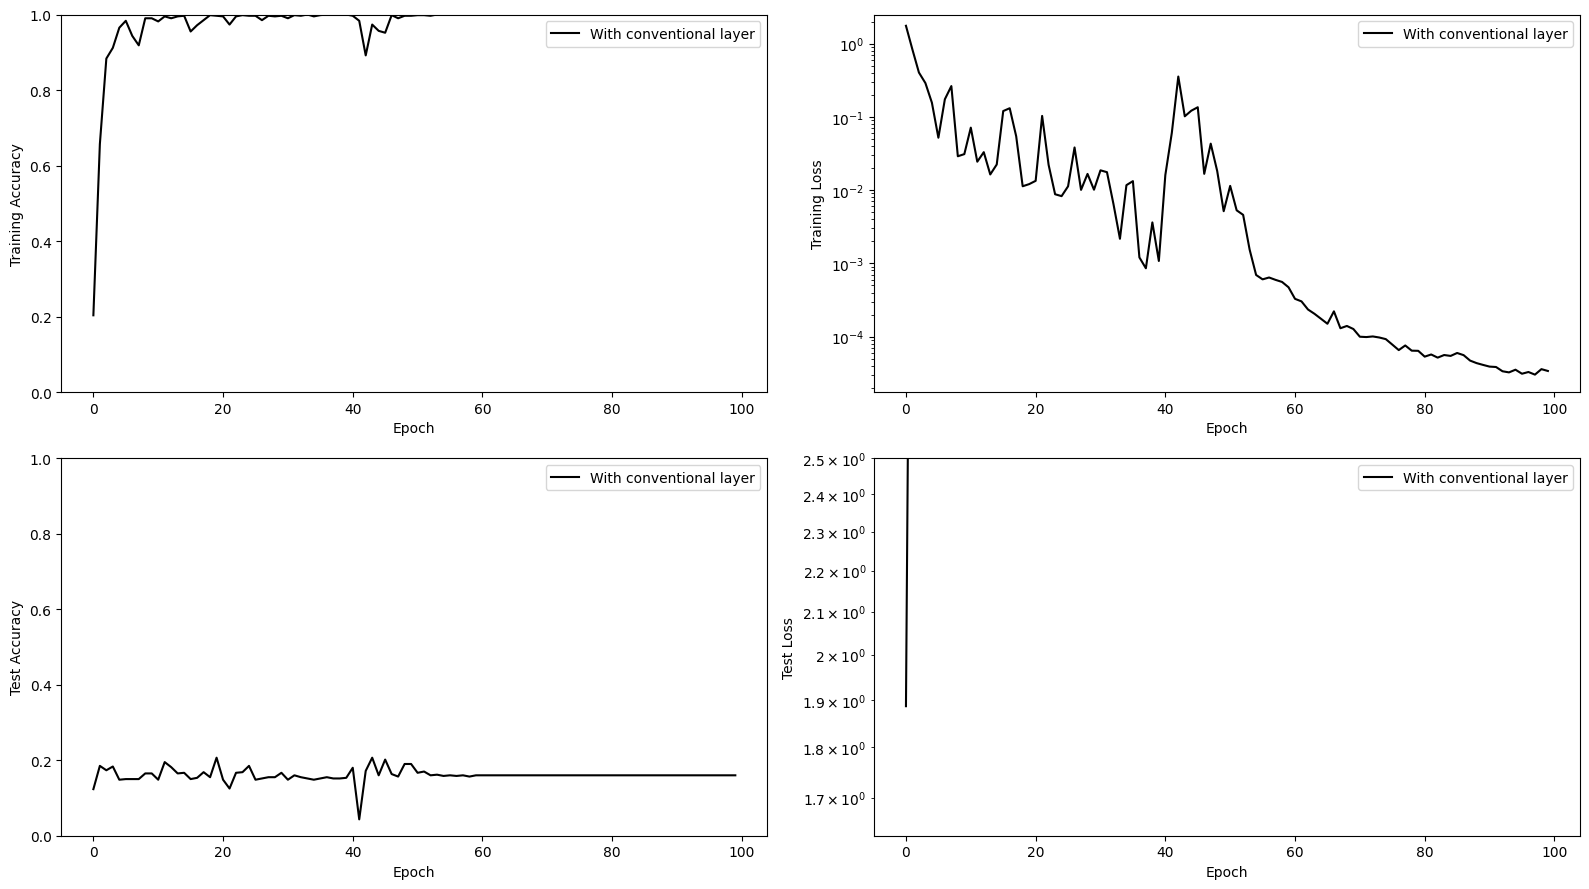

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

ax1.plot(c_history.history["accuracy"], "-k", label="With conventional layer")
ax1.set_ylabel("Training Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(c_history.history["loss"], "-k", label="With conventional layer")
ax2.set_yscale("log")
ax2.set_ylabel("Training Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

ax3.plot(c_history.history["val_accuracy"], "-k", label="With conventional layer")
ax3.set_ylabel("Test Accuracy")
ax3.set_ylim([0, 1])
ax3.set_xlabel("Epoch")
ax3.legend()

ax4.plot(c_history.history["val_loss"], "-k", label="With conventional layer")
ax4.set_yscale("log")
ax4.set_ylabel("Test Loss")
ax4.set_ylim(top=2.5)
ax4.set_xlabel("Epoch")
ax4.legend()

plt.tight_layout()
plt.show()

## Making it quantum

In the fully quantum attempt, we attempt to replace the convolutional layers with quanvolutional layers. Please note the training times will be longer, and multiple qubit runs must be made.

In [ ]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of classical input values from kernel
    for wire in range(kernel_size*kernel_size):
        qml.RY(np.pi * phi[wire], wires=wire)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(kernel_size*kernel_size)))

    # Measurement producing classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size*kernel_size)]

def generatefilter(image, j, k):
    """Lists out the neighboring cells useed for this convolution"""
    filter = []
    for j1 in range(0, kernel_size):
        for k1 in range(0, kernel_size):
            filter.append(image[j + j1, k + k1, 0])
    return filter

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((HEIGHT//kernel_size, LENGTH//kernel_size, kernel_size*kernel_size))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(0, HEIGHT - kernel_size + 1, kernel_size):
        for k in range(0, LENGTH - kernel_size + 1, kernel_size):
            # Process a squared region of the image with a quantum circuit
            q_results = circuit(generatefilter(image, j, k))
            # Assign expectation values to different channels of the output pixel as pooling layer
            for c in range(kernel_size*kernel_size):
                out[j // kernel_size, k // kernel_size, c] = q_results[c]
    return out

# Quantum circuit as a convolution kernel
dev = qml.device("default.qubit", wires=kernel_size*kernel_size+1)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_channels, kernel_size*kernel_size))
rand_params # A L × K² tensor

fig, axes = plt.subplots(1, n_channels, figsize=(10, 10))
for k in range(n_channels):
    axes[k].set_title("Channel {0:d}".format(k))
    axes[k].xaxis.set_visible(False)
    axes[k].yaxis.set_visible(False)
    print(rand_params[k].reshape([kernel_size,kernel_size]))
    axes[k].imshow(rand_params[k].reshape([kernel_size,kernel_size]), cmap="gray") # Lighter indicate higher value

class Quanv2D(keras.layer.Layer):
    def __init__(self, filters, kernel_size,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros"
    ):
        super().__init__()
        self.filters = filters
        self.kernel_size = standardize_tuple(kernel_size, rank, "kernel_size")
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        if self.filters is not None and self.filters <= 0:
            raise ValueError(
                "Invalid value for argument `filters`. Expected a strictly "
                f"positive value. Received filters={self.filters}."
            )
        if not all(self.kernel_size):
            raise ValueError(
                "The argument `kernel_size` cannot contain 0. Received "
                f"kernel_size={self.kernel_size}."
            )

        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.kernel_size*self.kernel_size, filters),
            initializer=self.kernel_initializer,
            # regularizer=self.kernel_regularizer,
            # constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                name="bias",
                shape=(self.filters,),
                initializer=self.bias_initializer,
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.bias = None

    def call(self, inputs):
        outputs = quanv(inputs)
        if self.use_bias:
            if self.data_format == "channels_last":
                bias_shape = (1,) * (self.rank + 1) + (self.filters,)
            else:
                bias_shape = (1, self.filters) + (1,) * self.rank
            bias = ops.reshape(self.bias, bias_shape)
            outputs += bias

        if self.activation is not None:
            return self.activation(outputs)
        return outputs